Ce Notebook présente une analyse sur l'offre en restaurants en France. Les données ont été crawlées à partir du site Tripadvisor.com (Decembre 2022) puis exportées sur une base MongoDB

In [1]:
#Imports
import os
import time
import re
import random
import concurrent.futures
import warnings
import datetime
import traceback

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from fake_useragent import UserAgent
from selenium.webdriver.chrome.service import Service

from tqdm.notebook import tqdm

from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import Future
from concurrent.futures import ThreadPoolExecutor, as_completed

warnings.filterwarnings("ignore",category = DeprecationWarning)

Partie 1 : Crawl des urls des villes sur Tripadvisor 

In [3]:
#A partir d'un url d'une ville sur Tripadvisor, recupere l'ensemble des restaurants de cette ville
def loop(url) :
    #Setting up Driver with fake user agent
    chrome_options = Options()
    ua = UserAgent()
    userAgent = ua.random
    chrome_options.add_argument(f'user-agent={userAgent}')
    path = r"path_to_chrome_driver"
    chrome_options.add_argument("--headless")
    chrome = webdriver.Chrome(executable_path= path ,options=chrome_options)
    chrome.maximize_window()
    chrome.get(url)
    time.sleep(3)
    #If there is the option to limit the search area of restaurants to save time 
    try :
        restrict_area_btn = chrome.find_element(By.CSS_SELECTOR,"div[id='geobroaden_opt_out']")
        chrome.execute_script("arguments[0].scrollIntoView();", restrict_area_btn)
        chrome.execute_script("arguments[0].click();",restrict_area_btn)
        time.sleep(1)
    except:
        pass
    #Crawl all restaurants urls and save them to file
    try :
        #First page of results
        lecture_url = chrome.find_elements(By.CSS_SELECTOR,"a[class='Lwqic Cj b']")
        hotels_urls = ["https://www.tripadvisor.fr"+url["href"] for url in lecture_url]
        with open("urls_restos.txt","a",encoding = "utf-8") as file :
            for hotel in hotels_urls :
                print(url+"\t"+hotel,file = file)
        i = 30
        while True :
            #Other pages , there are a max of 30 restaurants per page
            url_2 = url.split("-")[0]+"-"+url.split("-")[1]+"-oa{}".format(i)+"-"+url.split("-")[2]
            chrome.get(url_2)
            time.sleep(3)
            if chrome.current_url == url :
                break
            else :
                #Loop
                lecture_url = chrome.find_elements(By.CSS_SELECTOR,"a[class='Lwqic Cj b']")
                hotels_urls = ["https://www.tripadvisor.fr"+url["href"] for url in lecture_url]
                with open("urls_restos.txt","a",encoding = "utf-8") as file :
                    for hotel in hotels_urls :
                        print(url+"\t"+hotel,file = file)
                i = i+30
        chrome.quit()
    except:
        with open("failed_urls_restos.txt","a",encoding = "utf-8") as file :
            print(url,file = file)
            print(traceback.format_exc(),file = file)
        chrome.quit()
        
#Multithreading
with open("urls_pays_final.txt","r",encoding = "utf-8") as file :
    liste_pays_urls= file.readlines()
    liste_pays_urls = [url.replace("\n","") for url in liste_pays_urls]

try :
    with open("completed.txt","r",encoding = "utf-8") as log :
        done_urls= log.readlines()
        done_urls = [url.replace("\n","") for url in done_urls]
except:
    done_urls = []
liste_pays_urls = [url for url in liste_pays_urls if url not in done_urls]    
    
def main() :
    with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:
       	future_to_url = {executor.submit(loop, url): url for url in liste_pays_urls}
       	for future in tqdm(concurrent.futures.as_completed(future_to_url),total=len(future_to_url)):
       		url = future_to_url[future]
       		try:
       			data = future.result()
       		except Exception as exc:
       			with open('exception.txt',"a") as flog:
       				print('%r generated an exception: %s' % (url, exc),file=flog)
       				print(traceback.format_exc(),file=flog)
       		else:
       			with open('completed.txt',"a") as flog:
       				print('%r' % url,file=flog)
                     
if __name__ == "__main__":
    main()    

FileNotFoundError: [Errno 2] No such file or directory: 'urls_pays_final.txt'

Partie 2 : Crawl des informations sur les pages restaurants Tripadvisor

In [ ]:
#A partir d'un url de la page d'un restaurant sur Tripadvisor, recupere ses informations
def loop(url) :
    try :
        #Driver
        chrome_options = Options()
        ua = UserAgent()
        userAgent = ua.random
        chrome_options.add_argument(f'user-agent={userAgent}')
        path = r"path_to_chrome_driver"
        chrome_options.add_argument("--headless")
        chrome = webdriver.Chrome(executable_path= path ,options=chrome_options)
        chrome.maximize_window()
        chrome.get(url)
        time.sleep(0.5)
        #Gerer le popup sur la page 
        try :
            x = chrome.find_element(By.CSS_SELECTOR,"button[id='onetrust-accept-btn-handler']")
            chrome.execute_script("arguments[0].scrollIntoView();", x)
            chrome.execute_script("arguments[0].click();",x)
        except:
            pass
        #Recuperer le nom du restaurant
        try :
            lecture_nom = chrome.find_element(By.CSS_SELECTOR,"h1[class='HjBfq']")
            nom = lecture_nom.text
        except:
            nom = ""
        #Recuperer l'adresse du restaurant
        try :
            lecture_adrs = chrome.find_elements(By.CSS_SELECTOR,"a[class='AYHFM']")
            adrs = lecture_adrs[1].text
        except:
            adrs =""
        #Recuperer le type, classement du restaurant
        try :
            lecture_type = chrome.find_element(By.CSS_SELECTOR,"span[class='DsyBj cNFrA']")
            type_ = lecture_type.text.replace("xa0","").replace("\u202f","")
        except:
            type_ = ""
        #Recuperer la note  client du restaurant
        try :
            lecture_note = chrome.find_element(By.CSS_SELECTOR,"span[class='ZDEqb']")                                
            note = lecture_note.text
        except:
            note = ""
        #Recuperer les coordonnées gps du restaurant
        try :
            lecture_gps = chrome.find_element(By.CSS_SELECTOR,"img[class='w MD _S']")
            gps = re.search("(?<=center=)[^&]+",lecture_gps.get_attribute("src")).group()
        except :
            gps = ""
        #Recuperer le label MICHELIN du restaurant
        try :
            lecture_michelin = chrome.find_element(By.CSS_SELECTOR,"div[class='dfbUL S4 b H3']")
            michelin = lecture_michelin.text
        except:
            michelin =""
        #Recuperer le nombre d'étoiles michelin du restaurant
        try :
            lecture_note_michelin = chrome.find_element(By.CSS_SELECTOR,"img[class='REaHZ']")
            note_michelin = lecture_note_michelin.get_attribute("src")
            note_michelin = re.search("(?<=/)(.+)(?=svg)",note_michelin).group()
            note_michelin = note_michelin.split("/")[-1]
        except:
            note_michelin =""
        #Recuperer le nombre d'avis laissés par les clients sur le restaurant
        try :
            lecture_avis = chrome.find_element(By.CSS_SELECTOR,"span[class='AfQtZ']")
            avis = lecture_avis.text.replace("\u202f","")
        except:
            avis =""
        #Recuperer la catégorie de prix d urestaurant (€,€€-€€€ et €€€€)
        try :
            lecture_cuisine = chrome.find_element(By.CSS_SELECTOR,"span[class='DsyBj DxyfE']")
            cuisine = lecture_cuisine.find_elements(By.CSS_SELECTOR,"a[class='dlMOJ']")
            if "€" in cuisine[0].text :
                prix = cuisine[0].text
                cuisine_2 = [elem.text for elem in cuisine[1:]]
            else :
                prix = ""
                cuisine_2 = [elem.text for elem in cuisine]
        except:
            prix =""
            cuisine_2 = ""
        #Recuperer les notes sur la qualité, le service ...
        try :
            lecture_detail_notes = chrome.find_elements(By.CSS_SELECTOR,"div[class='DzMcu']")
            elements_details_notes = [elem.text for elem in lecture_detail_notes]
            notes_details_notes = [elem.find_element(By.CSS_SELECTOR,"span[class^='ui_bubble_rating']").get_attribute("class")
                                  for elem in lecture_detail_notes]
            notes_details_notes = [str(int(re.search("(\d+)",elem).group())/10)
                                  for elem in notes_details_notes]
        except:
            elements_details_notes = []
            notes_details_notes = []
        #Recuperer les horaires d'ouvertures du restaurant
        try :
            x = chrome.find_element(By.CSS_SELECTOR,"span[class='mMkhr']")
            chrome.execute_script("arguments[0].scrollIntoView();", x)
            chrome.execute_script("arguments[0].click();",x)
            time.sleep(0.25)
            lecture_horaires = chrome.find_elements(By.CSS_SELECTOR,"div[class='zuYLj']")
            horaires = lecture_horaires[0].text.replace("\n"," ")
        except Exception as e:
            horaires =""
        #Recuperer les informations secondaires du restaurant
        try :
            x = chrome.find_element(By.CSS_SELECTOR,"a[class='OTyAN _S b']")
            chrome.execute_script("arguments[0].scrollIntoView();", x)
            chrome.execute_script("arguments[0].click();",x)
            time.sleep(0.5)
            try :
                lecture_details_titres = chrome.find_elements(By.CSS_SELECTOR,"div[class='tbUiL b']")
                lecture_details_titres = [elem.text for elem in lecture_details_titres]
            except Exception as e:
                lecture_details_titres = []
            try:
                lecture_details = chrome.find_elements(By.CSS_SELECTOR,"div[class='SrqKb']")
                lecture_details = [[elem.text] for elem in lecture_details]
            except Exception as e:
                lecture_details = []
        except Exception as e:
            lecture_details_titres = []
            lecture_details = []
        #Sauvegarder les resultats
        try:
            result=(str(url)+'\t'+ str(nom)+ '\t'+ str(adrs)+ '\t'+ str(gps)+ '\t' 
                    + str(type_)+ '\t' +str(note)+ '\t' +str(michelin)+ '\t' +
                    str(note_michelin)+ '\t' +str(avis)+ '\t' +str(prix)+ '\t' +str(cuisine_2)
                    + '\t' +str(lecture_details_titres)
                    + '\t' +str(lecture_details)+ '\t' +str(elements_details_notes)
                    + '\t' +str(notes_details_notes)+ '\t' +str(horaires))
            with open('Infos_restos.csv','a',encoding='utf-8') as fhandle:
                print(result,file=fhandle)
        except :
            exception=(str(url)+'\t'+ ""+ '\t'+ ""+ '\t'
                    + ""+ '\t' +""+ '\t' +""+ '\t' +""+ '\t' +
                    ""+ '\t' +""+ '\t' +""+ '\t' +""+ '\t' +""
                    + '\t' +""+ '\t' +""+ '\t' +""+ '\t' +"")
            with open('Infos_restos.csv','a',encoding='utf-8') as fhandle:
                    print(exception,file=fhandle)
        chrome.quit()
    except Exception as e:
        exception=(str(url)+'\t'+ ""+ '\t'+ ""+ '\t'
                    + ""+ '\t' +""+ '\t' +""+ '\t' +""+ '\t' +
                    ""+ '\t' +""+ '\t' +""+ '\t' +""+ '\t' +""
                    + '\t' +""+ '\t' +""+ '\t' +""+ '\t' +"")
        with open('Infos_restos.csv','a',encoding='utf-8') as fhandle:
                print(exception,file=fhandle)
        chrome.quit()
        
#Multithreading
try :
    with open("Infos_restos.csv","r",encoding = "utf-8") as file :
        pass
except:
    with open('Infos_restos.csv','w',encoding='utf-8') as fhandle:
        print('url\tnom\tadress\tgps\tType\tNote\tMichelin\tNote Michelin\tNb Avis\tPrix\tCuisine\tTitres Details\tDetails\tTitres Details Notes\tDetails Notes\thoraires',file=fhandle)
    
with open("Urls_Prios.txt","r",encoding = "utf-8") as file :
    urls = file.readlines()
    urls = [url.replace("\n","").split("\t")[1] for url in urls[1:]]

try :
    with open("completed.txt","r",encoding = "utf-8") as log :
        done_urls= log.readlines()
        done_urls = [url.replace("\n","").replace("'","") for url in done_urls]
except:
    done_urls = []
urls = [url for url in urls if url not in done_urls]    
    
def main() :
    with concurrent.futures.ProcessPoolExecutor(max_workers=15) as executor:
       	future_to_url = {executor.submit(loop, url): url for url in urls}
       	for future in tqdm(concurrent.futures.as_completed(future_to_url),total=len(future_to_url)):
       		url = future_to_url[future]
       		try:
       			data = future.result()
       		except Exception as exc:
       			with open('exception.txt',"a") as flog:
       				print('%r generated an exception: %s' % (url, exc),file=flog)
       		else:
       			with open('completed.txt',"a") as flog:
       				print('%r' % url,file=flog)
                     
if __name__ == "__main__":
    main()      

Partie 3 : Mise en forme des données (après enrichissement des données) et envoit sur une base MongoDB

In [37]:
import pandas as pd
import pymongo
import json
import ast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
#Connection à Mongo en Localhost
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["General"]
mycol = mydb["Restaurants_France"]

In [ ]:
#Fichier Excel contenant les données restaurants
df_restos = pd.read_excel(open('Resultats_Restos_final.xlsx', 'rb'),sheet_name='Restos_France_2023')

In [ ]:
#Structuration des données et envoit sur la base
def mongo_pipe(row_number) :
    url = df_restos["url"].iloc[row_number]
    nom = df_restos["nom"].iloc[row_number]
    adress = df_restos["adress"].iloc[row_number]
    ville = df_restos["Ville"].iloc[row_number]
    insee = df_restos["Insee"].iloc[row_number]
    code_departement = df_restos["Code dep"].iloc[row_number]
    epci = df_restos["EPCI"].iloc[row_number]
    departement = df_restos["Departement"].iloc[row_number]
    region = df_restos["Region"].iloc[row_number]
    #Sur Mongo, la longitude est indiquée en premier
    try :
        longitude = float(df_restos["gps"].iloc[row_number].split(",")[1])
        latitude = float(df_restos["gps"].iloc[row_number].split(",")[0])
        coordinates = [longitude,latitude]
    except:
        coordinates = [0,0]
    ranking = df_restos["Type"].iloc[row_number]
    note = df_restos["Note"].iloc[row_number]
    michelin = df_restos["Michelin"].iloc[row_number]
    if michelin == "MICHELIN" :
        michelin = True
    else:
        michelin = False
    note_michelin = df_restos["Note Michelin"].iloc[row_number]
    nb_avis = df_restos["Nb Avis"].iloc[row_number]
    categorie_prix = df_restos["Prix"].iloc[row_number]
    prix_fiable = df_restos["Garder_Prix"].iloc[row_number]
    if prix_fiable == "OUI" :
        prix_fiable = True
    else:
        prix_fiable = False
    methode_prix = df_restos["Methode"].iloc[row_number]
    prix_bas = df_restos["Prix Bas Euros Final"].iloc[row_number]
    prix_haut = df_restos["Prix Haut Euros Final"].iloc[row_number]
    try :
        cuisine = ast.literal_eval(df_restos["Cuisine"].iloc[row_number])
    except:
        cuisine = []
    titres_infos = ast.literal_eval(df_restos["Titres Details"].iloc[row_number])
    infos = ast.literal_eval(df_restos["Details"].iloc[row_number])
    for i,titre in enumerate(titres_infos) :
        if titre == "":
            del titres_infos[i]
            del infos[i]
    for i,bloc in enumerate(infos) :
        infos[i] = [info.replace("\u202f","") for info in bloc]

    titres_notes = ast.literal_eval(df_restos["Titres Details Notes"].iloc[row_number])
    notes = ast.literal_eval(df_restos["Details Notes"].iloc[row_number])
    #Mise en forme des horaires pour avoir une liste contenant un dictionnaire
    #par jour d'ouverture. Les dictionnaires de jour contiennent des listes,
    #1 liste par période d'ouverture continue. Ces Listes contiennent les heures
    #d'ouvertures et de fermetures en format timestamp
    try :
        format = '%H:%M'
        clean_horaires = []
        x = df_restos["horaires"].iloc[row_number].replace("Le matin","Matin").split(" ")
        x = x[1:]
        indexes = {}
        for day in ["dim","lun","mar","mer","jeu","ven","sam"] :
            try :
                indexes[day] = x.index(day)
            except Exception as e :
                pass
        values = list(indexes.values())
        horaires_resto = {}
        for i,key in enumerate(indexes.keys()) :
            horaires_resto[key.title()] = []
            try :
                subList = [x[n:n+5] for n in range(values[i]+1, values[i+1]-1, 5)]
            except IndexError:
                subList = [x[n:n+5] for n in range(values[i]+1, len(x), 5)]
            for plages_ouvertures in subList :
                horaire_ouverture = plages_ouvertures[0]
                periode_ouverture = plages_ouvertures[1]
                if (periode_ouverture == "L'après-midi" and horaire_ouverture[:2] !="12"):
                    horaire_ouverture = datetime.strptime(horaire_ouverture, format)+ timedelta(hours=12) 
                else:
                    horaire_ouverture = datetime.strptime(horaire_ouverture, format)

                horaire_fermeture = plages_ouvertures[3]
                periode_fermeture = plages_ouvertures[4]
                if periode_fermeture == "Matin"  and horaire_fermeture =="12:00" :
                    horaire_fermeture = datetime.strptime("00:00", format)+ timedelta(days=1) 
                elif periode_fermeture == "Matin"  and horaire_fermeture =="12:30" :
                    horaire_fermeture = datetime.strptime("00:30", format)+ timedelta(days=1)

                elif periode_fermeture == "L'après-midi" and horaire_fermeture !="12:00"and horaire_fermeture !="12:30":
                    horaire_fermeture = datetime.strptime(horaire_fermeture, format)+ timedelta(hours=12) 
                elif ((periode_fermeture == "Matin"  and periode_ouverture == "L'après-midi") 
                    or(horaire_ouverture >  datetime.strptime(horaire_fermeture, format) and periode_ouverture =="Matin")) :
                    horaire_fermeture = datetime.strptime(horaire_fermeture, format)+ timedelta(days=1) 
                else:
                    horaire_fermeture = datetime.strptime(horaire_fermeture, format)

                #Export données
                horaires_resto[key.title()].append([horaire_ouverture,horaire_fermeture])
    except :
        horaires_resto = []

    #Create dictionnary
    infos_clean = {titre:info for titre,info in zip(titres_infos,infos)}
    infos_clean.pop('', None)
    notes_clean = {titres_note:note for titres_note,note in zip(titres_notes,notes)}
    notes_clean.pop('', None)
    dic = {"Url":url,"Nom":nom,"Adresse":adress,"Ville":ville,"Code_Insee":insee,
            "Epci":epci,"Code_Departement":code_departement,"Departement":departement,
            "Region":region,"location": {"coordinates": coordinates,"type": "Point"},
            "Classement":ranking,"Note_Client":note,"Michelin":michelin,"Note_Michelin":note_michelin,
            "Nb_Avis":nb_avis,"Categorie_Prix":categorie_prix,"Prix_Fiable":prix_fiable,
            "Methode_Prix":methode_prix,"Prix_Bas":prix_bas,"Prix_Haut":prix_haut,
            "Cuisines":cuisine,"Details":infos_clean,"Details_Notes":notes_clean,"Horaires":horaires_resto}
    mycol.insert_one(dic)

Partie 4 : Requetes sur la base de données MongoDB.

In [42]:
#Exemple sur le departement de Paris 
#Ecrire les noms sans guillements
zone_geographique = input("Entrer le nom de la zone d'étude, par exemple le département de Paris")
type_zone_geographique =input("Entrer le type de la zone d'étude : Ville, Departement,Epci ou Region")


In [106]:
#Fonction pour obtenir le nombre de restaurants et les prix
def query(field_to_group_by) :
    try :
        data = mycol.aggregate([
            {"$match" : {f"{type_zone_geographique}":f"{zone_geographique}"}},
            {"$facet": {
                "By_category":[
                    {"$group": {"_id": f"${field_to_group_by}", 
                        "Nb_restaurants": { "$sum": 1 },
                        "Prix_min_moyen": { "$avg": "$Prix_Bas"},
                        "Prix_max_moyen": { "$avg": "$Prix_Haut"},
                    }},
                    {"$addFields":{
                        "Prix_min_moyen" : {"$round":["$Prix_min_moyen",2]},
                        "Prix_max_moyen" : {"$round":["$Prix_max_moyen",2]},
                    }},
                    { "$sort": { "Nb_restaurants": -1 } }
                ],
                "TOTAL":[
                    {"$group": {"_id": "$null", 
                        "Nb_restaurants": { "$sum": 1 },
                        "Prix_min_moyen": { "$avg": "$Prix_Bas"},
                        "Prix_max_moyen": { "$avg": "$Prix_Haut"},
                    }},
                    {"$addFields":{
                        "Prix_min_moyen" : {"$round":["$Prix_min_moyen",2]},
                        "Prix_max_moyen" : {"$round":["$Prix_max_moyen",2]},
                    }},
                    { "$sort": { "Nb_restaurants": -1 } }
                ],
            }}
        ])
    except Exception as e:
        data = None
        print(e)
    return data

Partie 4-1 : Analyse par gamme de prix : Nombre de restaurants, Nombre de restaurants et établissements similaires, Prix moyen, note moyenne

In [150]:
#Mettre les données Sous Pandas
data = list(query("Categorie_Prix"))
categories = pd.DataFrame.from_dict(data[0]["By_category"])
total = pd.DataFrame.from_dict(data[0]["TOTAL"])
total["_id"] = ["TOTAL"]

#Concatener les categories et le total
full_data = pd.concat([categories,total],axis=0,ignore_index =True)
full_data['Prix_moyen'] = full_data[['Prix_min_moyen', 'Prix_max_moyen']].mean(axis=1).round(2)

#Calculer une colonne de Pourcentage par catégorie de Prix
full_data['Pourcentage'] = (full_data.Nb_restaurants / full_data.Nb_restaurants.sum()*2).round(2)

#Afficher
print(f"{type_zone_geographique} = {zone_geographique}")
full_data


Departement = Tarn-et-Garonne


,_id,Nb_restaurants,Prix_min_moyen,Prix_max_moyen,Prix_moyen,Pourcentage
0,€€-€€€,251,10.15,25.50,17.82,0.51
1,€,131,6.72,14.87,10.80,0.26
2,NaN,93,10.49,25.13,17.81,0.19
3,€€€€,22,18.61,42.01,30.31,0.04
4,TOTAL,497,9.68,23.36,16.52,1.00


Partie 4-2 : Analyse par EPCI : Nombre de restaurants, Nombre de restaurants et établissements similaires, Prix moyen, note moyenne

In [151]:
#Mettre les données Sous Pandas
data = list(query("Epci"))
categories = pd.DataFrame.from_dict(data[0]["By_category"])
total = pd.DataFrame.from_dict(data[0]["TOTAL"])
total["_id"] = ["TOTAL"]

#Concatener les categories et le total
full_data = pd.concat([categories,total],axis=0,ignore_index =True)
full_data['Prix_moyen'] = full_data[['Prix_min_moyen', 'Prix_max_moyen']].mean(axis=1).round(2)

#Calculer une colonne de Pourcentage par catégorie de Prix
full_data['Pourcentage'] = (full_data.Nb_restaurants / full_data.Nb_restaurants.sum()*2).round(2)

#Afficher
print(f"{type_zone_geographique} = {zone_geographique}")
full_data


Departement = Tarn-et-Garonne


,_id,Nb_restaurants,Prix_min_moyen,Prix_max_moyen,Prix_moyen,Pourcentage
0,CA Grand Montauban,227,9.14,22.36,15.75,0.46
1,CC Terres des Confluences,57,9.30,21.91,15.60,0.11
2,CC du Quercy Rouergue et des Gorges de l'Aveyron,49,11.14,25.02,18.08,0.10
3,CC du Quercy Caussadais,36,10.81,28.47,19.64,0.07
4,CC Grand Sud Tarn et Garonne,32,10.24,22.52,16.38,0.06
5,CC Quercy Vert-Aveyron,27,8.65,20.65,14.65,0.05
6,CC des Deux Rives,24,10.90,26.17,18.54,0.05
7,CC du Pays de Serres en Quercy,23,9.72,25.65,17.68,0.05
8,CC de la Lomagne Tarn-et-Garonnaise,13,11.29,24.56,17.92,0.03
9,CC Coteaux et Plaines du Pays Lafrançaisain,9,8.91,24.22,16.56,0.02


Partie 4-2 : Analyse des Cuisines les plus fréquentes

In [152]:
def query_cuisines():
    try :
        data = mycol.aggregate([
            {"$match" : {f"{type_zone_geographique}":f"{zone_geographique}"}},
            {"$facet": {
                "Nombre_total_restaurants": [
                    {"$group": {"_id": "null", 
                        "Nb_restaurants": { "$sum": 1 }}}
                ],
                "Nombre_restaurants_par_cuisine": [   
                    {"$unwind" : "$Cuisines" },
                    {"$group": {"_id": "$Cuisines", 
                                        "Nb_restaurants_cuisine": { "$sum": 1 }}
                                    },
                    { "$sort": { "Nb_restaurants_cuisine": -1 } }
                ],
            }}
        ])
    except Exception as e :
        data = None
        print(e)
    return data

#Mettre les données Sous Pandas
data = list(query_cuisines())
cuisines = pd.DataFrame.from_dict(data[0]["Nombre_restaurants_par_cuisine"])
total = data[0]["Nombre_total_restaurants"][0]["Nb_restaurants"]

#Calculer une colonne de Pourcentage 
cuisines['Pourcentage'] = (cuisines.Nb_restaurants_cuisine / total).round(2)

#Afficher
print(f"{type_zone_geographique} = {zone_geographique}")
print(f"Total number restaurants = {total}")
cuisines

Departement = Tarn-et-Garonne
Total number restaurants = 497


,_id,Nb_restaurants_cuisine,Pourcentage
0,Française,284,0.57
1,Européenne,103,0.21
2,Italienne,51,0.10
3,Pizza,49,0.10
4,Végétariens bienvenus,42,0.08
5,Restauration rapide,35,0.07
6,Asiatique,30,0.06
7,Bar,19,0.04
8,Chinoise,18,0.04
9,Américaine,17,0.03


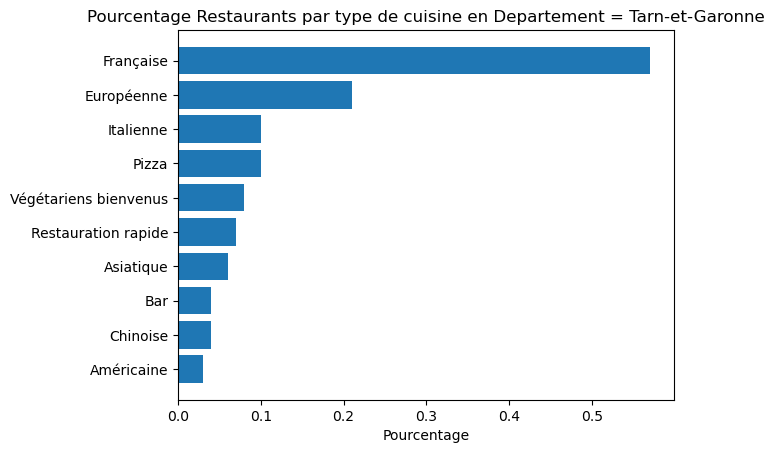

In [153]:
#Bar Chart
plt.rcdefaults()
fig, ax = plt.subplots()

labels = list(cuisines["_id"][:10])
y_pos = np.arange(len(labels))
percentage_graph = list(cuisines["Pourcentage"][:10])

ax.barh(y_pos, percentage_graph, align='center')
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Pourcentage')
ax.set_title(f'Pourcentage Restaurants par type de cuisine en {type_zone_geographique} = {zone_geographique}')

plt.show()

Partie 4-3 : Analyse du pourcentage de restaurants ouverts par heure

Partie 4-3-1 : Pourcentage Global par heure sur une semaine

In [92]:
format = '%H:%M'
hours = list(pd.date_range("00:30", "23:30", freq="30min").strftime(format))
hours.append("00:00")
results_days = []
results_heures = []
results_nb_ouverts = []
#Requete nombre global de restaurants dans la zone avec horaires renseignes
total_zone = mycol.aggregate([
            {"$match": {
                "$and":  [   
                        {f"{type_zone_geographique}":f"{zone_geographique}"},
                        {"Horaires": {"$exists" : "true", "$not": {"$size": 0}}},
                    ]
                }
            }
        ])
total = len(list(total_zone))
#Requete par heure et par jour
for day in tqdm(["Dim","Lun","Mar","Mer","Jeu","Ven","Sam"]) :
    for string_hour in hours :
        #On part du principe que les restaurants ouvre pour le jour N à min 7h
        if datetime.strptime(string_hour, format) <= datetime.strptime("07:00", format) :
            timestamp_hour = datetime.strptime(string_hour, format)+ timedelta(days=1)
        else :
            timestamp_hour = datetime.strptime(string_hour, format)
        #Requete pour obtenir le nombre de restaurants ouverts ce jour à cette heure
        nb_restaurants_ouverts = mycol.aggregate([
            {"$match": {
                "$and":  [   
                        {f"{type_zone_geographique}":f"{zone_geographique}"},
                        {"Horaires": {"$exists" : "true", "$not": {"$size": 0}}},
                        {f"Horaires.{day}.0.0" : {"$lte": timestamp_hour}},
                        {f"Horaires.{day}.0.1" : {"$gt": timestamp_hour}}
                    ]
                }
            }
        ])
        results_days.append(day)
        results_heures.append(string_hour)
        results_nb_ouverts.append(len(list(nb_restaurants_ouverts)))
dic = {"Jour":results_days,"Heure":results_heures,"Nombre_restaurants_ouverts":results_nb_ouverts}
df = pd.DataFrame.from_dict(dic)
print(f"{type_zone_geographique} = {zone_geographique} ==> {total} restos avec horaires")
df

100%|██████████| 7/7 [01:44<00:00, 14.99s/it]

Departement = Paris ==> 11488 restos avec horaires


,Jour,Heure,Nombre_restaurants_ouverts
0,Dim,00:30,1132
1,Dim,01:00,938
2,Dim,01:30,903
3,Dim,02:00,88
4,Dim,02:30,81
...,...,...,...
331,Sam,22:00,5038
332,Sam,22:30,4496
333,Sam,23:00,3443
334,Sam,23:30,3092


Partie 4-3-1 : Pourcentage Global par heure sur le dimanche

In [114]:
format = '%H:%M'
hours = list(pd.date_range("00:30", "23:30", freq="30min").strftime(format))
hours.append("00:00")
results_dimanche = []
results_heures_dimanche = []
results_nb_ouverts_dimanche = []
#Requete nombre global de restaurants dans la zone avec horaires renseignes
total_zone = mycol.aggregate([
            {"$match": {
                "$and":  [   
                        {f"{type_zone_geographique}":f"{zone_geographique}"},
                        {"Horaires.Dim": {"$exists" : "true", "$not": {"$size": 0}}},
                    ]
                }
            }
        ])
total = len(list(total_zone))
#Requete par heure et par jour
for day in tqdm(["Dim"]) :
    for string_hour in hours :
        #On part du principe que les restaurants ouvre pour le jour N à min 7h
        if datetime.strptime(string_hour, format) <= datetime.strptime("07:00", format) :
            timestamp_hour = datetime.strptime(string_hour, format)+ timedelta(days=1)
        else :
            timestamp_hour = datetime.strptime(string_hour, format)
        #Requete pour obtenir le nombre de restaurants ouverts ce jour à cette heure
        nb_restaurants_ouverts = mycol.aggregate([
            {"$match": {
                "$and":  [   
                        {f"{type_zone_geographique}":f"{zone_geographique}"},
                        {"Horaires": {"$exists" : "true", "$not": {"$size": 0}}},
                        {f"Horaires.{day}.0.0" : {"$lte": timestamp_hour}},
                        {f"Horaires.{day}.0.1" : {"$gt": timestamp_hour}}
                    ]
                }
            }
        ])
        results_dimanche.append(day)
        results_heures_dimanche.append(string_hour)
        results_nb_ouverts_dimanche.append(len(list(nb_restaurants_ouverts)))
dic = {"Jour":results_days,"Heure":results_heures,"Nombre_restaurants_ouverts":results_nb_ouverts}
dimanche = pd.DataFrame.from_dict(dic)
print(f"{type_zone_geographique} = {zone_geographique} ==> {total} restos ouverts le dimanche")
dimanche["Pourcentage_ouverts"] = (dimanche.Nombre_restaurants_ouverts / (total)).round(2)
dimanche

100%|██████████| 1/1 [00:13<00:00, 13.04s/it]

Departement = Paris ==> 7045 restos ouverts le dimanche


,Jour,Heure,Nombre_restaurants_ouverts,Pourcentage_ouverts
0,Dim,00:30,1132,0.16
1,Dim,01:00,938,0.13
2,Dim,01:30,903,0.13
3,Dim,02:00,88,0.01
4,Dim,02:30,81,0.01
5,Dim,03:00,65,0.01
6,Dim,03:30,65,0.01
7,Dim,04:00,56,0.01
8,Dim,04:30,56,0.01
9,Dim,05:00,22,0.00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\ibiza\AppData\Local\Temp\ipykernel_374852\2440716182.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


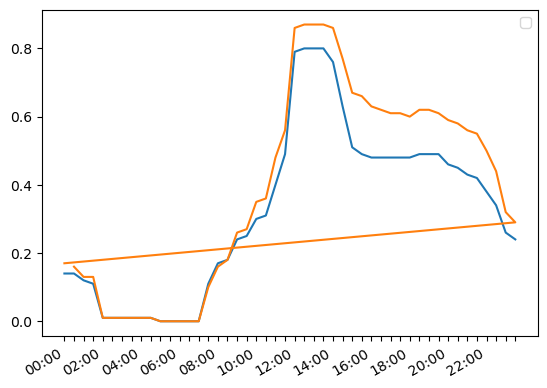

In [120]:
fig, ax = plt.subplots()
ax.plot(grouped["Heure"], grouped["Pourcentage_ouverts"])
ax.plot(dimanche["Heure"], dimanche["Pourcentage_ouverts"])

#ax.title('Taux d"ouverture des restaurants')
#ax.xlabel('Heure', fontsize=1)
#ax.ylabel('Pourcentage')
fig.autofmt_xdate()
n = 4  # Keeps every 4th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
plt.legend()
fig.show()